In [1]:
#import mathematics statics libraries
import numpy as np
import pandas as pd

#import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#import machine learning deep learning libraries
import tensorflow as tf
from tensorflow import keras


In [2]:
#load mnist datasets
(inp_tn, out_tn), (inp_ts, out_ts) = keras.datasets.mnist.load_data()


11501568/11490434 [==============================] - 0s 0us/step


In [3]:
#expand mnist dimensions
inp_tn = inp_tn.reshape(-1,28,28,1)
inp_ts = inp_ts.reshape(-1,28,28,1)


In [4]:
#create model function
def create_model(inp_shape,
                 conv_layers_num, conv_filters, conv_kernel_size,
                 dense_layers_num, dense_drop_ratio, dense_units,
                 out_drop_ratio, out_units, out_activation,
                 optimizer, loss , metric,
                 #layers batch drop configuration
                 conv_base = True, dense_head = True,
                 batch_norm_conv = True, batch_norm_dense = True, batch_norm_out = True,
                 drop_dense = True, drop_out = True,
                 #layers activation
                 conv_activation = 'relu', dense_activation = 'relu'):
    
    model = keras.Sequential()
    
    #define input layer
    model.add(keras.layers.InputLayer(input_shape = inp_shape))

    #define convolution layers
    if conv_base:
        for i in range(conv_layers_num):
            if batch_norm_conv:
                model.add(keras.layers.BatchNormalization())
            model.add(keras.layers.Conv2D(filters = conv_filters[i],
                                          kernel_size = conv_kernel_size[i], activation = conv_activation,
                                          kernel_initializer = keras.initializers.HeNormal()))
            model.add(keras.layers.MaxPool2D())

    #convert two dims to one dim
    model.add(keras.layers.Flatten())

    #define dense layers
    if dense_head:
        for i in range(dense_layers_num):
            if batch_norm_dense:
                model.add(keras.layers.BatchNormalization())
            if drop_dense:
                model.add(keras.layers.Dropout(dense_drop_ratio[i]))
            model.add(keras.layers.Dense(units = dense_units[i], activation = dense_activation,
                                         kernel_initializer = keras.initializers.HeNormal()))

    #define output layers
    if batch_norm_out:
        model.add(keras.layers.BatchNormalization())
    if drop_out:
        model.add(keras.layers.Dropout(out_drop_ratio))
    model.add(keras.layers.Dense(units = out_units, activation = out_activation))

    #define model compile
    model.compile(optimizer = optimizer,
                  loss = loss,
                  metrics = metric)

    return model


In [5]:
#define custom callbacks
class callback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
        if logs['accuracy'] >= 0.9990 or logs['val_accuracy'] >= 0.9990 :
            self.model.stop_training = True


In [6]:
model = create_model(inp_shape=(28,28,1),
                     conv_layers_num = 2, conv_filters = [128, 128], conv_kernel_size = [3, 3],
                     dense_layers_num = 2, dense_drop_ratio = [0.3, 0.3], dense_units = [256, 256],
                     #use only dense head without convolution base
                     conv_base = False, dense_head = True,
                     out_drop_ratio = 0.3, out_units = 10, out_activation = 'softmax',
                     optimizer = 'adam', loss = 'sparse_categorical_crossentropy' , metric = 'accuracy',
                     batch_norm_conv = True, batch_norm_dense = True, batch_norm_out = True,
                     drop_dense = False, drop_out = False,)


In [7]:
#print model summary
model.summary(120)


Model: "sequential"
________________________________________________________________________________________________________________________
 Layer (type)                                         Output Shape                                    Param #           
 flatten (Flatten)                                    (None, 784)                                     0                 
                                                                                                                        
 batch_normalization (BatchNormalization)             (None, 784)                                     3136              
                                                                                                                        
 dense (Dense)                                        (None, 256)                                     200960            
                                                                                                                        
 batch_norma

In [8]:
#fit model for training
history = model.fit(x = inp_tn, y = out_tn, epochs = 100, batch_size = 64, validation_data = (inp_ts, out_ts),
                    callbacks = [keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 10, restore_best_weights = True),
                                 keras.callbacks.CSVLogger('Logs.csv'), callback()])


Epoch 1/100
938/938 [==============================] - 17s 16ms/step - loss: 0.2058 - accuracy: 0.9372 - val_loss: 0.2558 - val_accuracy: 0.9631
Epoch 2/100
938/938 [==============================] - 14s 14ms/step - loss: 0.0891 - accuracy: 0.9719 - val_loss: 0.2042 - val_accuracy: 0.9668
Epoch 3/100
938/938 [==============================] - 10s 11ms/step - loss: 0.0619 - accuracy: 0.9800 - val_loss: 0.2308 - val_accuracy: 0.9706
Epoch 4/100
938/938 [==============================] - 8s 9ms/step - loss: 0.0438 - accuracy: 0.9858 - val_loss: 0.2759 - val_accuracy: 0.9730
Epoch 5/100
938/938 [==============================] - 8s 9ms/step - loss: 0.0400 - accuracy: 0.9867 - val_loss: 0.1713 - val_accuracy: 0.9727
Epoch 6/100
938/938 [==============================] - 8s 9ms/step - loss: 0.0327 - accuracy: 0.9894 - val_loss: 0.2310 - val_accuracy: 0.9740
Epoch 7/100
938/938 [==============================] - 8s 9ms/step - loss: 0.0282 - accuracy: 0.9909 - val_loss: 0.2257 - val_accuracy: 

In [9]:
#plot training history
hist_frame = pd.DataFrame(history.history)


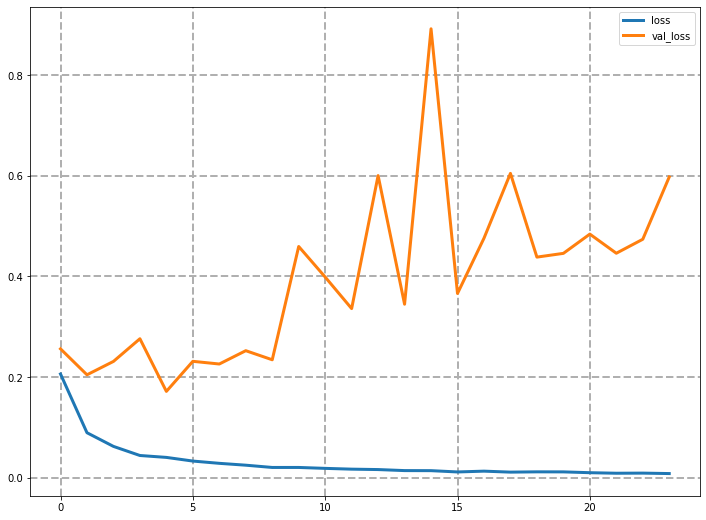

In [10]:
#plot loss
hist_frame[['loss', 'val_loss']].plot(figsize = (12,9), linewidth = 3)
plt.grid(linewidth = 2, linestyle = '--')


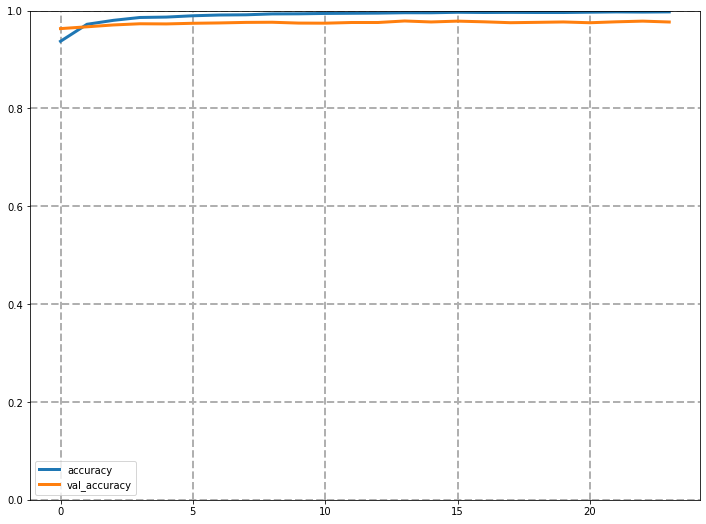

In [11]:
#plot accuracy
hist_frame[['accuracy', 'val_accuracy']].plot(figsize = (12,9), linewidth = 3)
plt.ylim(0,1)
plt.grid(linewidth = 2, linestyle = '--')


In [12]:
np.set_printoptions(linewidth = 320)

#print model test prediction
pred_ts = pd.DataFrame(model.predict(inp_ts))
count_pred_ts = (pred_ts.idxmax(axis = 1) == out_ts).value_counts()
print(count_pred_ts)

#print model test correct value counts
pred_ts.values

True     9787
False     213
dtype: int64


array([[5.4395088e-07, 1.7943054e-09, 3.0673096e-08, ..., 9.9987519e-01, 8.4354072e-11, 7.4050729e-07],
       [8.2588855e-08, 1.8793189e-10, 9.9999988e-01, ..., 2.0609856e-19, 3.4884605e-18, 3.5573706e-19],
       [2.5749325e-10, 9.9999893e-01, 2.0560757e-08, ..., 6.3611270e-07, 6.4430708e-08, 2.3215180e-11],
       ...,
       [1.4619403e-15, 6.4954156e-13, 8.5783526e-16, ..., 1.1818434e-09, 2.1050509e-10, 1.4952186e-09],
       [3.4306381e-11, 2.8132716e-10, 1.2527076e-04, ..., 9.2633679e-09, 1.5665619e-05, 8.9410138e-15],
       [2.2858895e-08, 5.0767034e-12, 4.7152783e-15, ..., 9.4568999e-14, 8.5395363e-15, 1.7361501e-15]], dtype=float32)

In [13]:
np.set_printoptions(linewidth = 320)

#print model train prediction
pred_tn = pd.DataFrame(model.predict(inp_tn))
count_pred_tn = (pred_tn.idxmax(axis = 1) == out_tn).value_counts()
print(count_pred_tn)

#print model train correct value counts
pred_tn.values

True     59722
False      278
dtype: int64


array([[9.31977979e-08, 1.73911317e-07, 2.79181659e-05, ..., 4.22181472e-08, 3.91481812e-11, 3.00871861e-08],
       [1.00000000e+00, 2.28760327e-12, 8.05722364e-11, ..., 1.40251810e-13, 1.23375945e-11, 2.05653064e-10],
       [1.95236148e-17, 1.64507453e-11, 7.45437376e-14, ..., 4.14037121e-12, 7.20778319e-17, 5.41039002e-13],
       ...,
       [1.41970647e-12, 4.28143603e-15, 3.19363238e-16, ..., 2.72172421e-13, 1.61297278e-11, 4.70719854e-08],
       [1.07416126e-04, 1.38240985e-09, 1.17305932e-09, ..., 3.07637721e-10, 4.05766497e-11, 3.41601643e-11],
       [3.71817706e-08, 2.11873713e-10, 5.06902751e-08, ..., 1.57145230e-09, 9.99999404e-01, 4.96643281e-07]], dtype=float32)

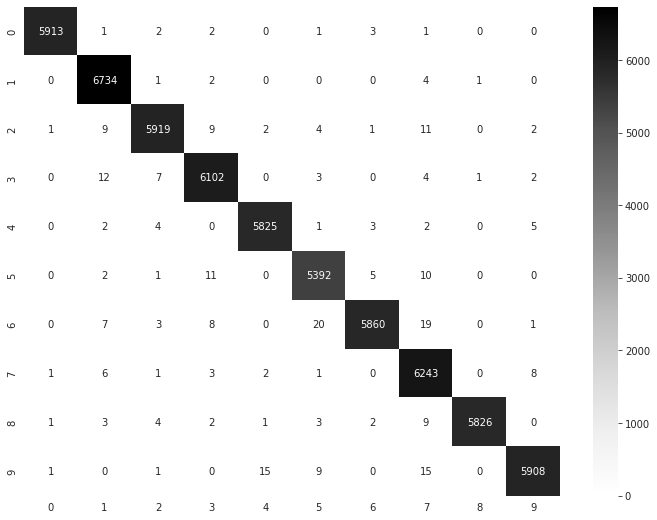

In [14]:
#plot confusion matrix
from sklearn.metrics import confusion_matrix

plt.figure(figsize = (12,9))
sns.set_style('dark')
sns.heatmap(confusion_matrix(out_tn, pred_tn.idxmax(axis = 1)),
            annot = True, fmt = '.0f', cmap = 'Greys')


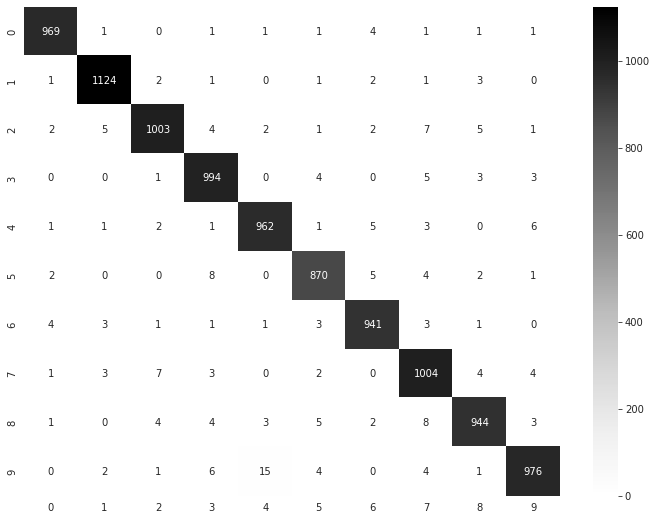

In [15]:
#plot confusion matrix
from sklearn.metrics import confusion_matrix

plt.figure(figsize = (12,9))
sns.heatmap(confusion_matrix(out_ts, pred_ts.idxmax(axis = 1)),
            annot = True, fmt = '.0f', cmap = 'Greys')


In [16]:
#save model
model.save('digits-mnist-recognition-dense-head.h5')
